*Valentina Alto has a great blog post on OLS linear regression! read it here: https://towardsdatascience.com/understanding-the-ols-method-for-simple-linear-regression-e0a4e8f692cc*

## Ordinary Least Squares Linear Regression
Linear regression is a simple linear approach that models the relationship between input variables $X$ and the single output variable $Y$

This can be implemented in a number of ways, most commonly through either ordinary least squares (OLS).

The linear regression problem can be formulated as such:

$Y = \alpha + \Sigma_{i=1..p} \beta_{i}X_{i} + \epsilon_{i}$

where $\epsilon$ is the error term, $\alpha$ is the value of the dependent variable $Y$ when the independent variables are $0$, and $\beta_{j}$ is the weight applied to the independent variable $X_{j}$

For now, lets consider the simple case where there is only one independent variable:

$Y = \alpha + \beta X + \epsilon$

or, for a single data point:

$y_{i} = \alpha + \beta x_{i} + \epsilon_{i}$

The goal here is to select values for $\alpha$ and $\beta$ that minimise the error term $\epsilon$. We can start by rearranging the formula:

$\epsilon_{i} = y_{i} - \alpha - \beta x_{i}$

thus for all data points...

$\Sigma_{i=1}^{n}\epsilon_{i} = \Sigma_{i=1}^{n}(y_{i} - \alpha - \beta x_{i}$)

As error could be positive or negative, we square $\epsilon$ to ensure all error contributes positively to the term:

$\Sigma_{i=1}^{n}\epsilon_{i}^{2} = \Sigma_{i=1}^{n}(y_{i} - \alpha - \beta x_{i})^{2}$

Now we can set about minimising $\epsilon$ by choosing good values for $\alpha$ and $\beta$. This is achieved through calculating the partial derivative of the function with respect to the parameters

let $L(\alpha, \beta) = \Sigma_{i=1}^{n}\epsilon_{i}^{2} = \Sigma_{i=1}^{n}(y_{i} - \alpha - \beta x_{i})^{2}$



Set to $0$ as this is the point of inflection (i.e. the minima)


$L(\alpha \beta) = \Sigma_{i=1}^{n}(y_{i} - \alpha - \beta x_{i})^{2}$

$L(\alpha \beta) = \Sigma_{i=1}^{n}(y_{i} - \alpha - \beta x_{i})(y_{i} - \alpha - \beta x_{i})$

$L(\alpha \beta) = \Sigma_{i=1}^{n} y_{i}^{2} + \alpha^{2} + (\beta x_{i})^{2} - 2y_{i}\alpha - 2y_{i}\beta x_{i} + 2abx_{i}$


Solve for $\beta$: 

$\frac{\delta L(\alpha, \beta)}{\delta \beta} = 0$

$\Sigma_{i=1}^{n} 2\alpha x_{i} - 2y_{i}x_{i} + 2\beta x_{i} = 0$ 

$\Sigma_{i=1}^{n}(y_{i} - \alpha - \beta x_{i})x_{i} = 0$

substituting $\Sigma_{i=1}^{n}\alpha = \Sigma_{i=1}^{n}y_{i}-\beta x_{i}$
$\alpha = \frac{\Sigma_{i=1}^{n}y_{i}-\beta x_{i}}{\Sigma_{i=1}^{n}}$

$\therefore \alpha = \bar{y} - \beta \bar{x}$

$\Sigma_{i=1}^{n}(y_{i} - (\bar{y} - \beta \bar{x}) - \beta x_{i})x_{i} = 0$

$\Sigma_{i=1}^{n} y_{i} - \bar{y} + \beta \bar{x} - \beta x_{i} = 0$

$\beta \Sigma_{i=1}^{n}(x_{i} - \bar{x}) = \Sigma_{i=1}^{n}(\bar{y} - y_{i})$

$\beta = \frac{\Sigma_{i=1}^{n}(y_{i} - \bar{y})}{\Sigma_{i=1}^{n}(x_{i} - \bar{x})}$


Solve for $\alpha$:

$\frac{\delta L(\alpha, \beta)}{\delta \alpha} = 0$

$\Sigma_{i=1}^{n} 2\alpha - 2y_{i} + 2\beta x_{i} = 0$ 

$\Sigma_{i=1}^{n} y_{i} -\alpha - \beta x_{i} = 0$ 

$\Sigma_{i=1}^{n} \alpha = \Sigma_{i=1}^{n} y_{i} - \beta x_{i}$ 

$\alpha = \frac{\Sigma_{i=1}^{n} y_{i} - \beta x_{i}}{\Sigma_{i=1}^{n}}$

$\alpha = \bar{y} - \beta \bar{x}$

with $\alpha$ and $\beta$ found, we now have our regression model by substituting these values back in to the equation above:

$y = \alpha + \beta x$


In [2]:
import jax.numpy as jnp
from jax import random, grad, jit, vmap, device_put
import matplotlib.pyplot as plt
from sklearn import datasets

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

2022-04-27 22:32:34.000833: W external/org_tensorflow/tensorflow/compiler/xla/service/platform_util.cc:200] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 8367046656


cpu


In [4]:
"""
Get dataset
Split into test and train
"""
diabetes_X, diabetes_Y = datasets.load_diabetes(return_X_y=True)

#Lets use just 1 independent variable
diabetes_X = diabetes_X[:,None,2]


diabetes_X_train = device_put(diabetes_X[:-20])
diabetes_X_test = device_put(diabetes_X[-20:])

diabetes_Y_train = device_put(diabetes_Y[:-20])
diabetes_Y_test = device_put(diabetes_Y[-20:])

type(diabetes_X_train)


jaxlib.xla_extension.DeviceArray

recall we need to find $\beta$ and $\alpha$. Let's start with $\beta$

$\beta = \frac{\Sigma_{i=1}^{n}(y_{i} - \bar{y})}{\Sigma_{i=1}^{n}(x_{i} - \bar{x})}$

In [5]:
def calc_numerator(arr1: jnp.array, arr2: jnp.array) -> float:
    mean1 = arr1.mean()
    mean2 = arr2.mean()
    
    return float(sum(
                    [(val1 - mean1)
                    *(val2 - mean2) 
                    for val1, val2 in zip(arr1, arr2)]))
    

def calc_denom(arr: jnp.array) -> float:
    mean = arr.mean()
    return float(sum([(val-mean)**2 for val in arr]))

beta = calc_numerator(diabetes_X_train,diabetes_Y_train)/calc_denom(diabetes_X_train)

beta



938.238225338989

$\alpha = \bar{y} - \beta \bar{x}$

In [6]:
alpha = diabetes_Y_train.mean() - (beta * diabetes_X_train.mean())
alpha


DeviceArray(152.91887, dtype=float32)

In [7]:
def MSE(y, y_pred):

    return sum([(y[i]-y_pred[i])**2 for i in range(len(y))])/len(y)

y_preds = []
for y,x in zip(diabetes_Y_test,diabetes_X_test):
    y_pred = alpha + (beta*x)
    y_preds.append(y_pred)


MSE(diabetes_Y_test, y_preds)    

DeviceArray([2548.072], dtype=float32)

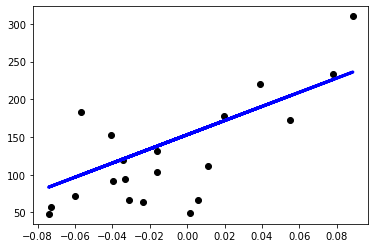

In [8]:
plt.scatter(diabetes_X_test, diabetes_Y_test, color="black")
plt.plot(diabetes_X_test, y_preds, color="blue", linewidth=3)

In [9]:
from sklearn import linear_model

regr = linear_model.LinearRegression()

regr.fit(diabetes_X_train, diabetes_Y_train)
regr.coef_

array([938.23785], dtype=float32)

In [10]:
diabetes_y_pred = regr.predict(diabetes_X_test)
MSE(diabetes_Y_test, diabetes_y_pred)

DeviceArray(2548.0725, dtype=float32)

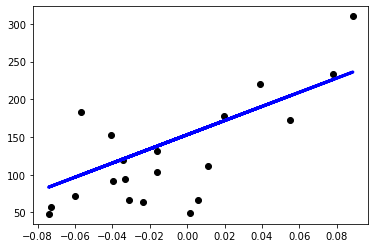

In [11]:
plt.scatter(diabetes_X_test, diabetes_Y_test, color="black")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)

In [3]:
a = [1,2,3]
b = [1,5,9]

a_ = 3
b_ = 4
print(sum([i-a_ for i in a])/sum([j-b_ for j in b]))

print(sum([i*(i-a_) for i in a])/sum([j*(j-b_) for j in b]))


-1.0
-1.0
